# Portfolio Optimization

- 포트폴리오 최적화 이론에 대한 정리 자료
- **포트폴리오**란, 다양한 자산에 분산하여 투자하는 것을 말함
- **분산투자**를 통해 변동성과 위험을 낮출 수 있음
- **자산 배분이란?** 위험 대비 수익을 최대화하는 포트폴리오를 구성하는 것

---
#### Tactical Asset Allocation(TAA)
- 위험 대비 수익을 "단기적으로" 최대화
- Smart Beta...

#### Strategic Asset Allocation(SAA)
- 위험 대비 수익을 "장기적으로" 최대화
- 일반적으로 위험과 수익률은 비례 관계
- SAA 모델은 위험(변동성)이 낮으면서 수익률이 높은 포트폴리오를 만드는 것이 목표
- Markowitz, Black-Litterman Model

---
#### 평균 수익률 (Expectation)
- 투자에 있어서 평균 수익률은 산술평균이 아닌 **기하평균**으로 계산되어야 함
- $E(R) = \frac{1}{N}\sum_{i=1}^{N}R_i$

#### 변동성 (Varience)
- $\sigma^2 = Var(R) = \frac{1}{N-1}\sum_{i=1}^{N}(R_i-\bar{R})$

#### 공분산 (Covarience)
- $Cov(R^1, R^2) = E[(R^1-\bar{R^1})(R^2-\bar{R^2})] = \frac{1}{N-1}\sum_{i=1}^{N}(R^1-\bar{R^1})(R^2-\bar{R^2})$

#### 상관관계 (Correlation Coefficient)
- $\rho = \cfrac{Cov(X,Y)}{Std(X)Std(Y)}, (-1\leq\rho\leq1)$

---
## 포트폴리오 기대수익과 위험 측정

#### 포트폴리오 정의
- 주어진 예산 내에서 자산 별 투자 비중
- $w = portfolio = [w_1, w_2, ... , w_N]^T, where \sum_{i=1}^{N}w_i = 1$

#### 포트폴리오의 기대 수익 (Weighted Average)
- 개별 자산의 기대수익률과 포트폴리오의 비중을 곱해서 합산
- $\mu_p = portfolio \times expectation = [w_1, w_2, ... , w_N][R_1, R_2, ... , R_N]^T$

#### 포트폴리오의 변동성 (=위험)
- $\sigma_p^2 = [w_1, w_2, ... , w_N]
 \begin{bmatrix}
  \sigma_{11} & \sigma_{12} & \cdots & \sigma_{1n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_{n^2} 
 \end{bmatrix}
 \begin{bmatrix}
  w_{1} \\
  w_{2} \\
  \vdots \\
  w_{N} \\
\end{bmatrix}
$

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
def get_dataset(code, start, end):
    df = pd.read_pickle("../dataset/{}.p".format(code))[::-1]
    df = df[df['date'].between(start, end, inclusive=True)]
    df = df.drop(['diff'], axis=1).set_index('date').sort_index()
    return df

# KAKAO 2017-01-01 ~ 2018-03-30
df = get_dataset('035720', '2017-01-01', '2018-03-30')
df.head()

,close,open,high,low,volume
date,,,,,
2017-01-02,76700.0,77400.0,77600.0,76600.0,143140.0
2017-01-03,80000.0,77200.0,80000.0,77000.0,445180.0
2017-01-04,84300.0,80400.0,85100.0,80300.0,1224395.0
2017-01-05,84000.0,85000.0,86000.0,84000.0,611713.0
2017-01-06,83700.0,84400.0,84500.0,82200.0,410880.0


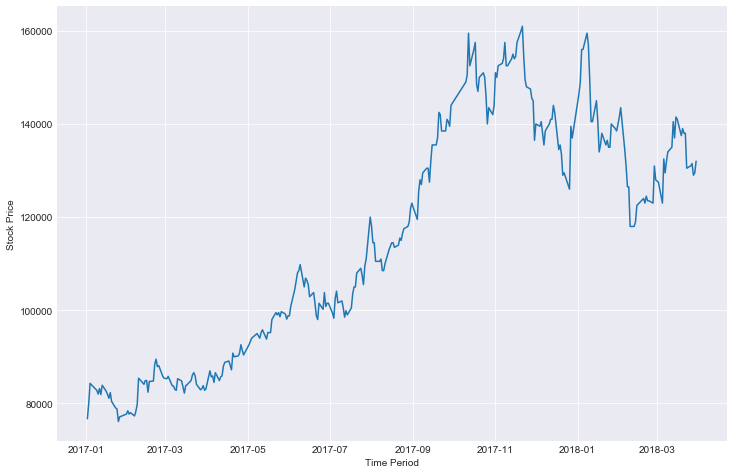

In [3]:
plt.figure(figsize=(12,8))
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
close_price = df['close']
plt.plot(close_price)

## Daily per change

<Container object of 304 artists>

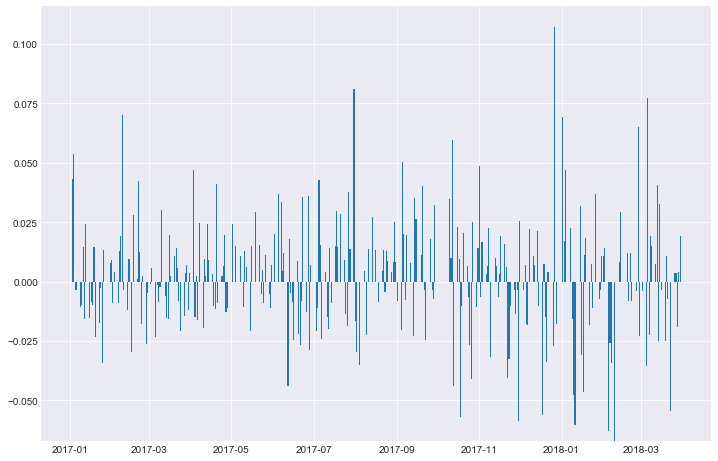

In [4]:
plt.figure(figsize=(12,8))
real_returns = close_price.pct_change()
plt.bar(real_returns.index,real_returns)

## Mean-Varience on Single Stock

In [5]:
def income(start, end):
    return round((end - start) / start * 100, 2)

def geometric_mean(iterable):
    iterable = [i for i in iterable if int(i) is not 0]
    a = np.log(iterable)
    return np.exp(a.sum()/len(a))

In [6]:
point = close_price[0]
result = close_price.apply(lambda d: income(point, d))
result.head()

date
2017-01-02    0.00
2017-01-03    4.30
2017-01-04    9.91
2017-01-05    9.52
2017-01-06    9.13
Name: close, dtype: float64

In [7]:
print("Mean of daily income: {}".format(np.mean(result)))
print("Geometric Mean of daily income: {}".format(geometric_mean(result)))
print("Varience of daily income: {}".format(np.var(result)))
print("Standard Deviation of daily income: {}".format(np.std(result)))

Mean of daily income: 50.12638157894736
Geometric Mean of daily income: 36.428618963268256
Varience of daily income: 1060.6134776965027
Standard Deviation of daily income: 32.56706123825886


## Mean-Varience on Portfolio
- 네이버(30%), 카카오(30%), 셀트리온(20%), SK이노베이션(20%)

In [8]:
def init_portfolio(stock, ratio, start, end):
    dfs = []
    for each in stock:
        df = get_dataset(each, start, end)['close']
        point = df[0]
        result = df.apply(lambda d: income(point, d))
        dfs.append(result)
    return pd.concat(dfs, axis=1, keys=stock)

def port_mean_var(avg_ret_, var_covar_, w_):
    port_ret = np.dot(w_, avg_ret_)
    port_std = np.dot(np.dot(w_, var_covar_), w_.T)
    return port_ret, port_std

In [9]:
stock = ['035420', '035720', '068270', '096770']
ratio = [0.3, 0.3, 0.2, 0.2]
df = init_portfolio(stock, ratio, '2017-01-01', '2018-03-30')
df.head()

,035420,035720,068270,096770
date,,,,
2017-01-02,0.00,0.00,0.00,0.00
2017-01-03,-1.29,4.30,-1.48,5.44
2017-01-04,4.25,9.91,-1.94,6.12
2017-01-05,1.80,9.52,-1.66,4.76
2017-01-06,2.83,9.13,-2.68,6.80


In [10]:
avg_ret = df.mean()
var_covar = df.cov()
w = np.array(ratio).T
mean, var = port_mean_var(avg_ret, var_covar, w)

print("Mean of portfolio: {}".format(mean))
print("Varience of portfolio: {}".format(var))

Mean of portfolio: 31.353697368421052
Varience of portfolio: 681.8218582117422
